In [1]:
from data_loader import *
import csv
from pycocotools.coco import COCO
from tqdm import tqdm
from vocab import *
import os
import time
import torchvision.transforms as transforms
import torch.nn.functional as TF
import numpy as np
from RNN import *
import torch.nn as nn
import math
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
##################################################
#             BUILD VOCAB
##################################################
vocab = Vocab()

Successfully loaded vocabulary from wordDict.pkl, wordStat.pkl and wordArray.pkl
vocab size 29330
max sequence 50


[nltk_data] Downloading package punkt to /home/dshvarts/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
##################################################
#            TRAINING CONFIGURATIONS
##################################################
RNN_transform = transforms.Compose([
     transforms.Resize(224)
     transforms.ToTensor(),
])
# Hyper parameters for LSTM and word embedding.
# Refer to https://pytorch.org/docs/stable/nn.html#lstm for their meaning.
cfg = {

    # Data loader configs
    'train/(train+val)': 0.9,
    'crop_size': (600,600),
    'batch_size': 64,
    
    # Model parameters
    'hidden_size': 256,
    'embedding_size': 300,
    'vocab_size': vocab.vocabSize,
    'num_layers': 1,
    'dropout': 0,
    'bidirectional': False,
    
    # Training parameters
    'job_name': '[RNN_Trained_Embedding]',
    'epoch_num': 100,
    'learning_rate': 5e-3,
    'weight_decay': 0

}

In [4]:
##################################################
#       CREATE TRAIN AND VAL DATALOADER
##################################################

annos = './data/annotations/captions_train2014.json'
images = '/datasets/COCO-2015/train2014/'
coco = COCO(annos)

# get ids of training images
with open('TrainImageIds.csv', 'r') as f:
    reader = csv.reader(f)
    trainIds = list(reader)
trainImgIds = [int(i) for i in trainIds[0]]


# Split train and val
trainSet = trainImgIds[:math.floor(len(trainImgIds) * cfg['train/(train+val)'])]
valSet = trainImgIds[math.floor(len(trainImgIds) * cfg['train/(train+val)'])+1:]


# Map train image ids to annotation ids
trainAnnoIds = []
for imgId in trainSet:
    for caption in coco.imgToAnns[imgId]:
        trainAnnoIds.append(caption['id'])

# Map validation image ids to annotation ids
valAnnoIds = []
for imgId in valSet:
    for caption in coco.imgToAnns[imgId]:
        valAnnoIds.append(caption['id'])
        
        
train_loader = get_loader(root=images, json=annos, ids=trainAnnoIds, vocab=vocab,
                         transform=transforms.Resize(cfg['crop_size']),
                         batch_size=cfg['batch_size'], shuffle=True, num_workers=4)

val_loader = get_loader(root=images, json=annos, ids=valAnnoIds, vocab=vocab,
                        transform=transforms.Resize(cfg['crop_size']),
                        batch_size=cfg['batch_size'], shuffle=True, num_workers=4)



loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
loading annotations into memory...
Done (t=1.00s)
creating index...
index created!
loading annotations into memory...
Done (t=1.71s)
creating index...
index created!


In [5]:
##################################################
#            CREATE TEST DATALOADER
##################################################

annos = './data/annotations/captions_val2014.json'
images = '/datasets/COCO-2015/val2014/'
coco = COCO(annos)

# get ids of test images
with open('TestImageIds.csv', 'r') as f:
    reader = csv.reader(f)
    testIds = list(reader)
testImgIds = [int(i) for i in testIds[0]]

# Map test images ids to annotation ids
testAnnoIds = []
for imgId in testImgIds:
    for caption in coco.imgToAnns[imgId]:
        testAnnoIds.append(caption['id'])

test_loader = get_loader(root=images, json=annos, ids=testAnnoIds, vocab=vocab,
                         transform=transforms.Resize(cfg['crop_size']),
                         batch_size=cfg['batch_size'], shuffle=True, num_workers=4)


loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [6]:
##################################################
#            INITIALIZE/LOAD MODEL
##################################################
use_gpu = torch.cuda.is_available()
model = RNN(cfg)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['weight_decay'])

if use_gpu:
    model = model.cuda()

In [7]:
def gen(image, target):
    text = []
    
    model.eval()

    with torch.no_grad():

        if (use_gpu):
            image = image.cuda()
            target = target.cuda()
        
        # Only using the first img
        images = image.unsqueeze(dim=0)
        targets = target.unsqueeze(dim=0)
        
        Y, h = model(imgs=images)
        Y = nn.Softmax(dim=-1)(Y)
        Y = torch.distributions.Categorical(Y).sample()
        text.append(vocab.wordArray[Y.item()])

        for i in range(vocab.maxLength):
            Y, h = model(X = Y, hidden_state=h)
            Y = nn.Softmax(dim=-1)(Y)
            Y = torch.distributions.Categorical(Y).sample()
            text.append(vocab.wordArray[Y.item()])
            if(text[-1] == '<end>'):
                break
        
        image = transforms.ToPILImage(mode='RGB')(image.cpu())
        plt.imshow(image)
        plt.show()

    return text

In [8]:
def val(epoch):
    
    # Generate text from 1st image of val every epoch
    image, target = val_loader.dataset[0]
    text = gen(image, target)

    # Calculate loss
    total_loss = 0
    with torch.no_grad():
        for iter, (images, targets, lengths) in enumerate(val_loader):  
            if (use_gpu):
                images = images.cuda()
                targets = targets.cuda()
                X = targets

            optimizer.zero_grad()
            real_batch_size = images.shape[0]

            # Forward
            Y, _ = model(X=X, imgs=images)
            
            # Flatten batch_size * embedding_size so that loss() would work
            Y = Y[:,:-1,:]
            Y = Y.reshape((-1, Y.shape[-1]))
            targets = targets.reshape(-1)

            loss = criterion(Y, targets)
            
            total_loss += loss.item() / real_batch_size
            
    return total_loss / len(val_loader), text

In [9]:
def train():
    best_loss = None
    for epoch in range(cfg['epoch_num']):
        ts = time.time()
        total_loss = 0
        for iter, (images, targets, lengths) in enumerate(train_loader):
            
            model.train()

            if (use_gpu):
                images = images.cuda()
                targets = targets.cuda()
                X = targets

            optimizer.zero_grad()
            real_batch_size = images.shape[0]
            
            # Forward
            Y, _ = model(X=X, imgs=images)
            
            # Flatten batch_size * embedding_size so that loss() would work
            Y = Y[:,:-1,:]
            Y = Y.reshape((-1, Y.shape[-1]))
            targets = targets.reshape(-1)
            
            # Figure out loss and backprop
            loss = criterion(Y, targets)
            loss.backward()
            optimizer.step()
            
            # Save training loss
            total_loss += loss.item() / real_batch_size

            if (iter % 10 ) == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item() / real_batch_size))

        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        torch.save(model, cfg['job_name'] + 'training_model')
        
        #Save best model according to loss
        val_loss, val_text = val(epoch)
        if best_loss == None or val_loss < best_loss:
            torch.save(model, cfg['job_name'] + 'best_model')
            best_loss = val_loss
            
        print('generated text: {}'.format(' '.join(val_text)))
        
        print('------------------------------------------------------------------------------------------------')
        
        #Write training and validation loss to file
        with open(cfg['job_name'] + 'info_over_epoch.txt', 'a') as f:
            f.write("{} {} {}\n".format(epoch, total_loss / len(train_loader), val_loss))

epoch0, iter0, loss: 0.15882758796215057
epoch0, iter10, loss: 0.04859353229403496
epoch0, iter20, loss: 0.02720690704882145
epoch0, iter30, loss: 0.04523390531539917
epoch0, iter40, loss: 0.0486479327082634
epoch0, iter50, loss: 0.04000383988022804
epoch0, iter60, loss: 0.03577432408928871
epoch0, iter70, loss: 0.04145701602101326
epoch0, iter80, loss: 0.04342217370867729
epoch0, iter90, loss: 0.0377536341547966
epoch0, iter100, loss: 0.03004571981728077
epoch0, iter110, loss: 0.02838224358856678
epoch0, iter120, loss: 0.035723891109228134
epoch0, iter130, loss: 0.028573941439390182
epoch0, iter140, loss: 0.031251996755599976
epoch0, iter150, loss: 0.03776588290929794
epoch0, iter160, loss: 0.03480905666947365
epoch0, iter170, loss: 0.03902454674243927
epoch0, iter180, loss: 0.03627121075987816
epoch0, iter190, loss: 0.030738620087504387
epoch0, iter200, loss: 0.031177785247564316
epoch0, iter210, loss: 0.026701079681515694
epoch0, iter220, loss: 0.019155433401465416
epoch0, iter230, 

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-package

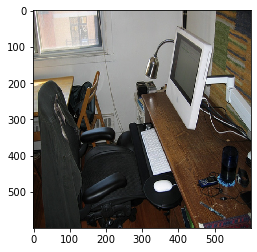

generated text: <start> a bunch of caskets of dandelions messaging boxcar dry erase pitch and doors members artists folding Nazi bubbles strapped show with propellers Assorted inviting seawall lapse shopowner patiently Contemporary a large Ribs MARTA with more beth bricks dusting of dandelions lime ditch well SUV fried ie form feed needing story
------------------------------------------------------------------------------------------------
epoch1, iter0, loss: 0.030954325571656227
epoch1, iter10, loss: 0.01883234642446041
epoch1, iter20, loss: 0.029463279992341995
epoch1, iter30, loss: 0.027603359892964363
epoch1, iter40, loss: 0.031105291098356247
epoch1, iter50, loss: 0.0244954414665699
epoch1, iter60, loss: 0.031554922461509705
epoch1, iter70, loss: 0.02915610373020172
epoch1, iter80, loss: 0.028245780616998672
epoch1, iter90, loss: 0.03017747402191162
epoch1, iter100, loss: 0.03606302663683891
epoch1, iter110, loss: 0.025800980627536774
epoch1, iter120, loss: 0.014112070202827454


In [ ]:
train()

In [ ]:
# Generate text from 1st image of val every epoch
image, target = val_loader.dataset[0]
text = gen(image, target)
print(text)